## Import des packages

- tqdm : barre de progression
- pathlib : gestion des chemins de fichiers
- librosa : traitement audio
- os : gestion des fichiers
- torch : PyTorch
- numpy : calculs numériques
- soundfile : lecture/écriture de fichiers audio
- s3prl : framework d'extraction de features audio
- sklearn : outils de machine learning

In [1]:
import math
from pathlib import Path

import torch
import torch.nn as nn
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import TensorDataset, DataLoader

## Paramètres globaux

- random_seed : graine aléatoire pour reproductibilité
- device : choix du device (GPU si disponible, sinon CPU)
- embedding_path : chemin vers le dossier de sauvegarde des embeddings extraits
- saved_model_path : chemin vers les sauvegardes des modeles

In [2]:
random_seed = 42
limit = 200

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

embedding_path = Path("./16k_Hz_embedding/")
pooled_path = Path("./16k_Hz_pooled/")

# Pooled versions paths
pooled_mean_path = pooled_path / "mean"
pooled_max_path = pooled_path / "max"
pooled_mean_std_path = pooled_path / "mean_std"

test_mean_path = pooled_mean_path / "_test.pt"
test_max_path = pooled_max_path / "_test.pt"
test_mean_std_path = pooled_mean_std_path / "_test.pt"

saved_MLP_model_path = "./saved_MLP.pth"

# Not pooled versions paths
transformer_path = embedding_path / "transformer"

test_transformer_path = transformer_path / "_test.pt"

saved_transformer_model_path = "./saved_transformer.pth"

AUDIO_EXTENSIONS = (".wav", ".mp3", ".flac", ".ogg", ".m4a")

Device: cpu


## Fonctions utilitaires pour associer les fichiers audio à leurs émotions
- find_emotion_T : fonction pour la base TESS
- emotionfix : fonction pour ajuster les indices d'émotions pour la classification

In [3]:
# Emotion kind validation function for TESS database, due to emotions written within the file names.
def find_emotion_T(name):
    if 'neutral' in name:
        return "01"
    elif 'happy' in name or 'joy' in name or 'positive' in name:
        return "03"
    elif 'sad' in name or 'sadness' in name or 'pain' in name:
        return "04"
    elif 'angry' in name or 'anger' in name:
        return "05"
    elif 'fear' in name:
        return "06"
    elif 'disgust' in name or 'negative' in name:
        return "07"
    elif 'ps' in name or 'surprise' in name:
        return "08"
    else:
        return "-1"


# 'emotions' list fix for classification purposes:
#     Classification values start from 0, Thus an 'n = n-1' operation has been executed for both RAVDESS and TESS databases:
def emotionfix(e_num):
    if e_num == "01":
        return 0  # neutral
    elif e_num == "02":
        return 1  # calm
    elif e_num == "03":
        return 2  # happy
    elif e_num == "04":
        return 3  # sad
    elif e_num == "05":
        return 4  # angry
    elif e_num == "06":
        return 5  # fear
    elif e_num == "07":
        return 6  # disgust
    else:
        return 7  # suprised

labels = [0,1,2,3,4,5,6,7]

## Chargement des differents sets pour la methode de pooling renseignée et association des enregistrements à leur label

In [4]:
def load_split(file_list, base_path, is_transformer=False):
    embeddings, labels = [], []
    nb_par_classes = [0 for _ in range(8)]

    for file_name in file_list:

        if not file_name.startswith("_") and file_name.endswith(".pt"):

            # 1) Charge l'embedding
            emb = torch.load(base_path / file_name)  # tensor

            # 2) Détecte l'émotion
            emo_code = find_emotion_T(file_name)
            if emo_code == "-1":
                emo_code = file_name[6:8]  # RAVDESS
            label = emotionfix(emo_code)
            nb_par_classes[label] += 1

            embeddings.append(emb)
            labels.append(label)
    if is_transformer:
        X = pad_sequence(embeddings, batch_first=True)
    else:
        X = torch.stack(embeddings)
    y = torch.tensor(labels)
    print("\t - ",nb_par_classes)

    return X, y

## Classifier MLP

In [5]:
# -------------------------
# 1) MLP Classifier
# -------------------------
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        return self.net(x)

    def save(self, path):
        torch.save(self.net.state_dict(), path)

    def load(self, path):
        self.net.load_state_dict(torch.load(path))

## Classifier Transformer

In [6]:
# -------------------------
# 2) Transformer léger (sequence-based)
# -------------------------
# Ici on suppose que X_train est (N, seq_len, hidden_dim) càd embeddings NON poolés (mean/max/mean_std)
# Pour transformer, il faut des embeddings frame-level.

# -------------------------
# Dataset et DataLoader pour Transformer avec mask
# -------------------------
class PadDataset(torch.utils.data.Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


# --- collate fn: explicit pad_value and mask generation ---
PAD_VALUE = 0.0   # use 0.0 padding (consistent with mask logic)

def collate_fn(batch, pad_value=PAD_VALUE):
    X_batch, y_batch = zip(*batch)                     # each X is (seq_len_i, dim)
    # pad_sequence expects list of tensors (seq_len, dim) -> returns (batch, max_seq_len, dim)
    X_batch = pad_sequence(X_batch, batch_first=True, padding_value=pad_value)
    y_batch = torch.tensor(y_batch, dtype=torch.long)

    # Mask: True for real tokens (non-padding)
    # Use norm instead of abs.sum for clarity
    mask = (X_batch.norm(dim=2) != pad_value)   # True = token real if pad_value is 0.0
    return X_batch, y_batch, mask

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=1000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1)]
        return x


# --- Improved TransformerClassifier: projection -> smaller d_model, LN, dropout, classifier head ---
class TransformerClassifier(nn.Module):
    def __init__(self, input_dim, num_classes, d_model=256, n_layers=2, n_heads=8, dropout=0.1, ff_dim=512):
        super().__init__()
        # project input embeddings down to smaller d_model
        self.input_proj = nn.Linear(input_dim, d_model)
        self.pos_encoding = PositionalEncoding(d_model, max_len=1200)  # safe margin
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=n_heads,
            dim_feedforward=ff_dim,
            dropout=dropout,
            batch_first=True
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=n_layers)
        self.cls_token = nn.Parameter(torch.randn(1, 1, d_model))
        self.layernorm = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)
        # small classifier head
        self.fc = nn.Sequential(
            nn.Linear(d_model, d_model // 2),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout),
            nn.Linear(d_model // 2, num_classes)
        )

    def forward(self, x, mask=None):
        # x: (B, S, input_dim)
        b = x.size(0)
        x = self.input_proj(x)   # (B, S, d_model)

        cls_tokens = self.cls_token.expand(b, -1, -1)   # (B,1,d_model)
        x = torch.cat((cls_tokens, x), dim=1)           # (B, S+1, d_model)
        x = self.pos_encoding(x)
        x = self.layernorm(x)

        if mask is not None:
            # mask: (B, S): True for real tokens (no cls). Need cls_mask True for cls token.
            cls_mask = torch.ones((b, 1), dtype=torch.bool, device=x.device)
            mask = torch.cat((cls_mask, mask), dim=1)   # (B, S+1)
            src_key_padding_mask = ~mask   # True = padding positions to be ignored
            x = self.encoder(x, src_key_padding_mask=src_key_padding_mask)
        else:
            x = self.encoder(x)

        cls_out = x[:, 0, :]                 # (B, d_model)
        cls_out = self.dropout(cls_out)
        return self.fc(cls_out)

    def save(self, path):
        torch.save(self.state_dict(), path)

    def load(self, path):
        self.load_state_dict(torch.load(path))

## Evaluation (MLP)

In [7]:
def evaluate_MLP(model, loader):
    model.eval()
    correct, total = 0, 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for X_batch, y_batch in loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            preds = model(X_batch).argmax(dim=1)

            # ACCUMULATION
            all_preds.append(preds.cpu())
            all_labels.append(y_batch.cpu())

            correct += (preds == y_batch).sum().item()
            total += y_batch.size(0)
    # CONCATENATE EVERYTHING
    all_preds = torch.cat(all_preds)
    all_labels = torch.cat(all_labels)

    return correct / total, all_preds, all_labels

## Evaluation (transformer)

In [8]:
def evaluate_transformer(model, data_loader):
    model.eval()
    correct, total = 0, 0
    all_preds, all_labels = [], []
    with torch.no_grad():
        for X_batch, y_batch, mask in data_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            mask = mask.to(device)
            logits = model(X_batch, mask)
            preds = logits.argmax(dim=1)

            # ACCUMULATION
            all_preds.append(preds.cpu())
            all_labels.append(y_batch.cpu())

            correct += (preds == y_batch).sum().item()
            total += y_batch.size(0)

    # CONCATENATE EVERYTHING
    all_preds = torch.cat(all_preds)
    all_labels = torch.cat(all_labels)

    return correct / total if total > 0 else 0.0, all_preds, all_labels

## Assignation de la methode au chemin vers les sets

In [9]:
paths = {
    "mean": test_mean_path,
    "max": test_max_path,
    "mean_std": test_mean_std_path,
    "transformer": test_transformer_path
}

## Chargement du Test sets et assignation des enregistrements aux émotions

In [10]:
pooling_type = "mean"  # "max", "mean_std", "transformer"
batch_size = 16
num_classes = 8

test_path = paths[pooling_type]

test_files = torch.load(test_path)

print("Number of example for each class\nTest :")
X_test, y_test = load_split(test_files, pooled_mean_path)

print(f"[TRANSFORMER] Loaded splits:")
print("Test  :", X_test.shape, y_test.shape)

MLP_test_dataset = TensorDataset(X_test, y_test)

MLP_test_loader = DataLoader(MLP_test_dataset, batch_size=batch_size)

Number of example for each class
Test :
	 -  [65, 39, 76, 69, 98, 85, 97, 108]
[TRANSFORMER] Loaded splits:
Test  : torch.Size([637, 1024]) torch.Size([637])


## Chargement du MLP

In [11]:
input_dim = X_test.shape[1]
mlp_model = MLPClassifier(input_dim, num_classes).to(device)
mlp_model.load(saved_MLP_model_path)

## Test du MLP et affichage des resultats

torch.Size([637]) torch.Size([637])
[MLP] Test Accuracy: 0.874


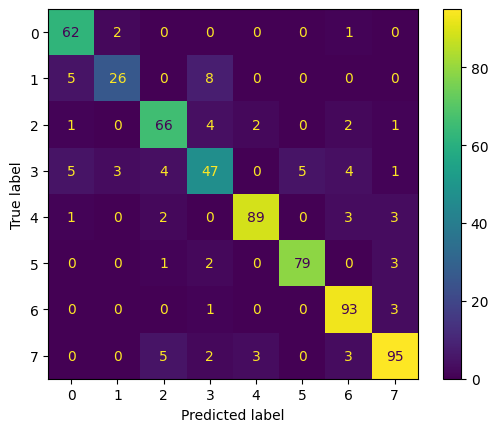

In [12]:
mlp_test_acc, mlp_test_preds, test_labels = evaluate_MLP(mlp_model, MLP_test_loader)
print(mlp_test_preds.shape, test_labels.shape)
print(f"[MLP] Test Accuracy: {mlp_test_acc:.3f}")

# Confusion matrix
disp_CM = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(test_labels, mlp_test_preds, labels=labels),display_labels=labels)
disp_CM.plot()

## Chargement du Test sets et assignation des enregistrements aux émotions

In [13]:
test_files = torch.load(test_transformer_path)

print("Number of example for each class\nTest :")
X_test, y_test = load_split(test_files, embedding_path, is_transformer=True)

print(f"[TRANSFORMER] Loaded splits:")
print("Test  :", X_test.shape, y_test.shape)

transformer_test_loader = DataLoader(PadDataset(X_test, y_test), batch_size=batch_size, collate_fn=collate_fn)

Number of example for each class
Test :
	 -  [62, 26, 95, 95, 92, 91, 85, 90]
[TRANSFORMER] Loaded splits:
Test  : torch.Size([636, 256, 1024]) torch.Size([636])


## Chargement du transformer

In [14]:
input_dim = X_test.shape[2]
transformer_model = TransformerClassifier(input_dim, num_classes).to(device)
transformer_model.load(saved_transformer_model_path)

## Test du transformer et affichage des resultats

/Users/alves/These/code/WavLM_SER/.venv/lib/python3.12/site-packages/torch/nn/modules/transformer.py:515: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. We recommend specifying layout=torch.jagged when constructing a nested tensor, as this layout receives active development, has better operator coverage, and works with torch.compile. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/NestedTensorImpl.cpp:182.)
  output = torch._nested_tensor_from_mask(


torch.Size([636]) torch.Size([636])
[Transformer] Test Accuracy: 0.893


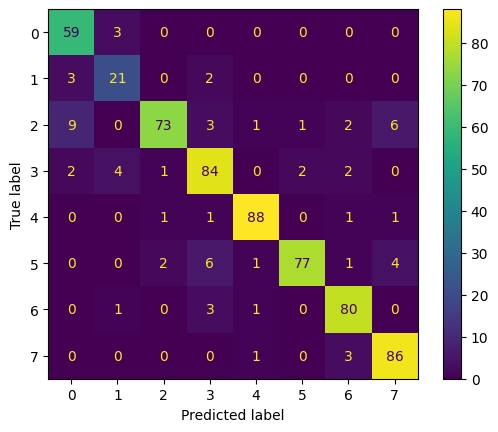

In [15]:
transformer_test_acc, transformer_test_preds, test_labels = evaluate_transformer(transformer_model, transformer_test_loader)
print(transformer_test_preds.shape, test_labels.shape)
print(f"[Transformer] Test Accuracy: {transformer_test_acc:.3f}")

# Confusion matrix
disp_CM = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(test_labels, transformer_test_preds, labels=labels),display_labels=labels)
disp_CM.plot()